In [30]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [31]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 84.1 GB  | Proc size: 1.2 GB
GPU RAM Free: 10928MB | Used: 5240MB | Util  32% | Total 16376MB


In [32]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))]
    )
    trainset = FashionMNIST("./dataset", train=True, download=True, transform=transform)
    testset = FashionMNIST("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

In [33]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [34]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [35]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [36]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [37]:
strategy = FedCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,  # <-- pass the new strategy here
    client_resources=client_resources,

)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-16 09:47:22,963	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 27570328780.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'memory': 55140657563.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49060) Training time for Client 1: 26.95 seconds
(ClientAppActor pid=49060) Epoch 9: train loss 0.011451, accuracy 0.870185 [repeated 4x across cluster]
(ClientAppActor pid=30468) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.433287143707275and 4habhhahah
this is tehb mode time [25.43]
This is ths last time not a fantasy 26.94545865058899and 1habhhahah
this is tehb mode time [25.43, 26.95]
This is ths last time not a fantasy 24.92915940284729and 8habhhahah
this is tehb mode time [25.43, 26.95, 24.93]
This is ths last time not a fantasy 25.137451887130737and 9habhhahah
this is tehb mode time [25.43, 26.95, 24.93, 25.14]
This is ths last time not a fantasy 24.774789094924927and 2habhhahah
this is tehb mode time [25.43, 26.95, 24.93, 25.14, 24.77]
This is ths last time not a fantasy 24.827754974365234and 0habhhahah
this is tehb mode time [25.43, 26.95, 24.93, 25.14, 24.77, 24.83]
This is ths last time not a fantasy 27.116679191589355and 7habhhahah
this is tehb mode time [25.43, 26.95, 24.93, 25.14, 24.77, 24.83, 27.12]
This is ths last time not a fantasy 25.012444972991943and 6habhhahah
this is tehb mode time [25.43, 26.95, 24.93, 25.14, 24.77, 24.83, 27.12, 25.01]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30468) Training time for Client 5: 24.27 seconds
(ClientAppActor pid=23760) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.269104957580566and 5habhhahah
this is tehb mode time [24.27]
This is ths last time not a fantasy 24.286782026290894and 3habhhahah
this is tehb mode time [24.27, 24.29]
This is ths last time not a fantasy 22.617637634277344and 1habhhahah
this is tehb mode time [24.27, 24.29, 22.62]
This is ths last time not a fantasy 22.029576778411865and 9habhhahah
this is tehb mode time [24.27, 24.29, 22.62, 22.03]
This is ths last time not a fantasy 22.58642816543579and 2habhhahah
this is tehb mode time [24.27, 24.29, 22.62, 22.03, 22.59]
This is ths last time not a fantasy 22.056588888168335and 8habhhahah
this is tehb mode time [24.27, 24.29, 22.62, 22.03, 22.59, 22.06]
This is ths last time not a fantasy 21.858994722366333and 0habhhahah
this is tehb mode time [24.27, 24.29, 22.62, 22.03, 22.59, 22.06, 21.86]
This is ths last time not a fantasy 21.88874840736389and 7habhhahah
this is tehb mode time [24.27, 24.29, 22.62, 22.03, 22.59, 22.06, 21.86, 21.89]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12224) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 23.939366579055786and 6habhhahah
this is tehb mode time [23.94]
This is ths last time not a fantasy 22.44766354560852and 3habhhahah
this is tehb mode time [23.94, 22.45]
This is ths last time not a fantasy 22.191219091415405and 5habhhahah
this is tehb mode time [23.94, 22.45, 22.19]
This is ths last time not a fantasy 21.64761209487915and 9habhhahah
this is tehb mode time [23.94, 22.45, 22.19, 21.65]
This is ths last time not a fantasy 22.05864453315735and 7habhhahah
this is tehb mode time [23.94, 22.45, 22.19, 21.65, 22.06]
This is ths last time not a fantasy 24.12924337387085and 4habhhahah
this is tehb mode time [23.94, 22.45, 22.19, 21.65, 22.06, 24.13]
This is ths last time not a fantasy 22.098628282546997and 8habhhahah
this is tehb mode time [23.94, 22.45, 22.19, 21.65, 22.06, 24.13, 22.1]
This is ths last time not a fantasy 21.860040426254272and 1habhhahah
this is tehb mode time [23.94, 22.45, 22.19, 21.65, 22.06, 24.13, 22.1, 21.86]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30468) Epoch 9: train loss 0.003617, accuracy 0.957778 [repeated 4x across cluster]
(ClientAppActor pid=30468) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 26.63115096092224and 2habhhahah
this is tehb mode time [26.63]
This is ths last time not a fantasy 24.802130222320557and 9habhhahah
this is tehb mode time [26.63, 24.8]
This is ths last time not a fantasy 21.95360779762268and 5habhhahah
this is tehb mode time [26.63, 24.8, 21.95]
This is ths last time not a fantasy 24.362308979034424and 8habhhahah
this is tehb mode time [26.63, 24.8, 21.95, 24.36]
This is ths last time not a fantasy 22.21966028213501and 4habhhahah
this is tehb mode time [26.63, 24.8, 21.95, 24.36, 22.22]
This is ths last time not a fantasy 24.275665044784546and 0habhhahah
this is tehb mode time [26.63, 24.8, 21.95, 24.36, 22.22, 24.28]
This is ths last time not a fantasy 21.742902278900146and 3habhhahah
this is tehb mode time [26.63, 24.8, 21.95, 24.36, 22.22, 24.28, 21.74]
This is ths last time not a fantasy 24.02678918838501and 1habhhahah
this is tehb mode time [26.63, 24.8, 21.95, 24.36, 22.22, 24.28, 21.74, 24.03]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=30468) Training time for Client 6: 24.16 seconds


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=300) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.293782472610474and 5habhhahah
this is tehb mode time [22.29]
This is ths last time not a fantasy 22.200405597686768and 8habhhahah
this is tehb mode time [22.29, 22.2]
This is ths last time not a fantasy 21.833760738372803and 3habhhahah
this is tehb mode time [22.29, 22.2, 21.83]
This is ths last time not a fantasy 22.027952671051025and 0habhhahah
this is tehb mode time [22.29, 22.2, 21.83, 22.03]
This is ths last time not a fantasy 21.89176034927368and 4habhhahah
this is tehb mode time [22.29, 22.2, 21.83, 22.03, 21.89]
This is ths last time not a fantasy 21.932233810424805and 2habhhahah
this is tehb mode time [22.29, 22.2, 21.83, 22.03, 21.89, 21.93]
This is ths last time not a fantasy 22.050501823425293and 1habhhahah
this is tehb mode time [22.29, 22.2, 21.83, 22.03, 21.89, 21.93, 22.05]
This is ths last time not a fantasy 21.840583324432373and 9habhhahah
this is tehb mode time [22.29, 22.2, 21.83, 22.03, 21.89, 21.93, 22.05, 21.84]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18572) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.23469829559326and 8habhhahah
this is tehb mode time [22.23]
This is ths last time not a fantasy 22.292535543441772and 3habhhahah
this is tehb mode time [22.23, 22.29]
This is ths last time not a fantasy 21.798205852508545and 5habhhahah
this is tehb mode time [22.23, 22.29, 21.8]
This is ths last time not a fantasy 21.810550212860107and 2habhhahah
this is tehb mode time [22.23, 22.29, 21.8, 21.81]
This is ths last time not a fantasy 22.076460599899292and 4habhhahah
this is tehb mode time [22.23, 22.29, 21.8, 21.81, 22.08]
This is ths last time not a fantasy 22.199531078338623and 0habhhahah
this is tehb mode time [22.23, 22.29, 21.8, 21.81, 22.08, 22.2]
This is ths last time not a fantasy 24.11692190170288and 6habhhahah
this is tehb mode time [22.23, 22.29, 21.8, 21.81, 22.08, 22.2, 24.12]
This is ths last time not a fantasy 22.491230964660645and 9habhhahah
this is tehb mode time [22.23, 22.29, 21.8, 21.81, 22.08, 22.2, 24.12, 22.49]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30468) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.52689242362976and 2habhhahah
this is tehb mode time [21.53]
This is ths last time not a fantasy 24.490315914154053and 7habhhahah
this is tehb mode time [21.53, 24.49]
This is ths last time not a fantasy 21.92780041694641and 9habhhahah
this is tehb mode time [21.53, 24.49, 21.93]
This is ths last time not a fantasy 22.27074885368347and 4habhhahah
this is tehb mode time [21.53, 24.49, 21.93, 22.27]
This is ths last time not a fantasy 22.49311923980713and 6habhhahah
this is tehb mode time [21.53, 24.49, 21.93, 22.27, 22.49]
This is ths last time not a fantasy 23.963507175445557and 1habhhahah
this is tehb mode time [21.53, 24.49, 21.93, 22.27, 22.49, 23.96]
This is ths last time not a fantasy 22.166746377944946and 0habhhahah
this is tehb mode time [21.53, 24.49, 21.93, 22.27, 22.49, 23.96, 22.17]
This is ths last time not a fantasy 22.448516845703125and 3habhhahah
this is tehb mode time [21.53, 24.49, 21.93, 22.27, 22.49, 23.96, 22.17, 22.45]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30468) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.158940076828003and 5habhhahah
this is tehb mode time [24.16]
This is ths last time not a fantasy 22.207526683807373and 4habhhahah
this is tehb mode time [24.16, 22.21]
This is ths last time not a fantasy 21.582260847091675and 1habhhahah
this is tehb mode time [24.16, 22.21, 21.58]
This is ths last time not a fantasy 24.297832012176514and 2habhhahah
this is tehb mode time [24.16, 22.21, 21.58, 24.3]
This is ths last time not a fantasy 24.4938702583313and 9habhhahah
this is tehb mode time [24.16, 22.21, 21.58, 24.3, 24.49]
This is ths last time not a fantasy 22.135900020599365and 6habhhahah
this is tehb mode time [24.16, 22.21, 21.58, 24.3, 24.49, 22.14]
This is ths last time not a fantasy 22.321266651153564and 7habhhahah
this is tehb mode time [24.16, 22.21, 21.58, 24.3, 24.49, 22.14, 22.32]
This is ths last time not a fantasy 22.326613664627075and 3habhhahah
this is tehb mode time [24.16, 22.21, 21.58, 24.3, 24.49, 22.14, 22.32, 22.33]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18572) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.664849758148193and 9habhhahah
this is tehb mode time [21.66]
This is ths last time not a fantasy 24.239603757858276and 0habhhahah
this is tehb mode time [21.66, 24.24]
This is ths last time not a fantasy 22.279239177703857and 4habhhahah
this is tehb mode time [21.66, 24.24, 22.28]
This is ths last time not a fantasy 21.899871826171875and 7habhhahah
this is tehb mode time [21.66, 24.24, 22.28, 21.9]
This is ths last time not a fantasy 21.984357833862305and 1habhhahah
this is tehb mode time [21.66, 24.24, 22.28, 21.9, 21.98]
This is ths last time not a fantasy 21.949957609176636and 3habhhahah
this is tehb mode time [21.66, 24.24, 22.28, 21.9, 21.98, 21.95]
This is ths last time not a fantasy 24.685254335403442and 8habhhahah
this is tehb mode time [21.66, 24.24, 22.28, 21.9, 21.98, 21.95, 24.69]
This is ths last time not a fantasy 22.27906632423401and 6habhhahah
this is tehb mode time [21.66, 24.24, 22.28, 21.9, 21.98, 21.95, 24.69, 22.28]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49060) Epoch 9: train loss 0.000575, accuracy 0.995556 [repeated 4x across cluster]
(ClientAppActor pid=49060) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=49060) Training time for Client 2: 26.85 seconds


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 500.91s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01548027362426122
INFO :      		round 2: 0.011165011912584304
INFO :      		round 3: 0.010832280836999417
INFO :      		round 4: 0.01130549588489036
INFO :      		round 5: 0.012085171731188895
INFO :      		round 6: 0.012570767879486083
INFO :      		round 7: 0.013883371298511823
INFO :      		round 8: 0.014449043056617181
INFO :      		round 9: 0.015007918427698315
INFO :      		round 10: 0.015849493865699817
INFO :      


History (loss, distributed):
	round 1: 0.01548027362426122
	round 2: 0.011165011912584304
	round 3: 0.010832280836999417
	round 4: 0.01130549588489036
	round 5: 0.012085171731188895
	round 6: 0.012570767879486083
	round 7: 0.013883371298511823
	round 8: 0.014449043056617181
	round 9: 0.015007918427698315
	round 10: 0.015849493865699817

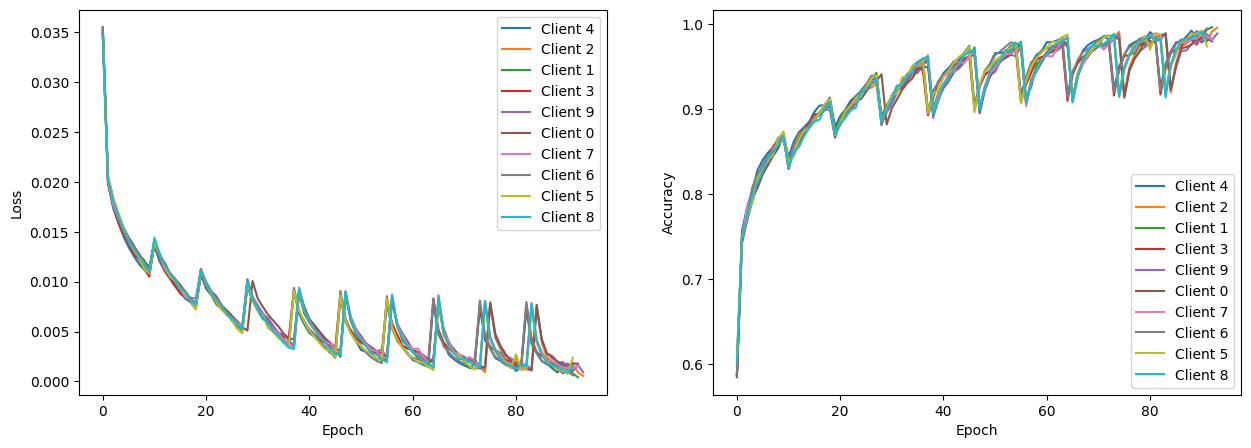

In [38]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

plot_metrics(strategy.client_metrics)

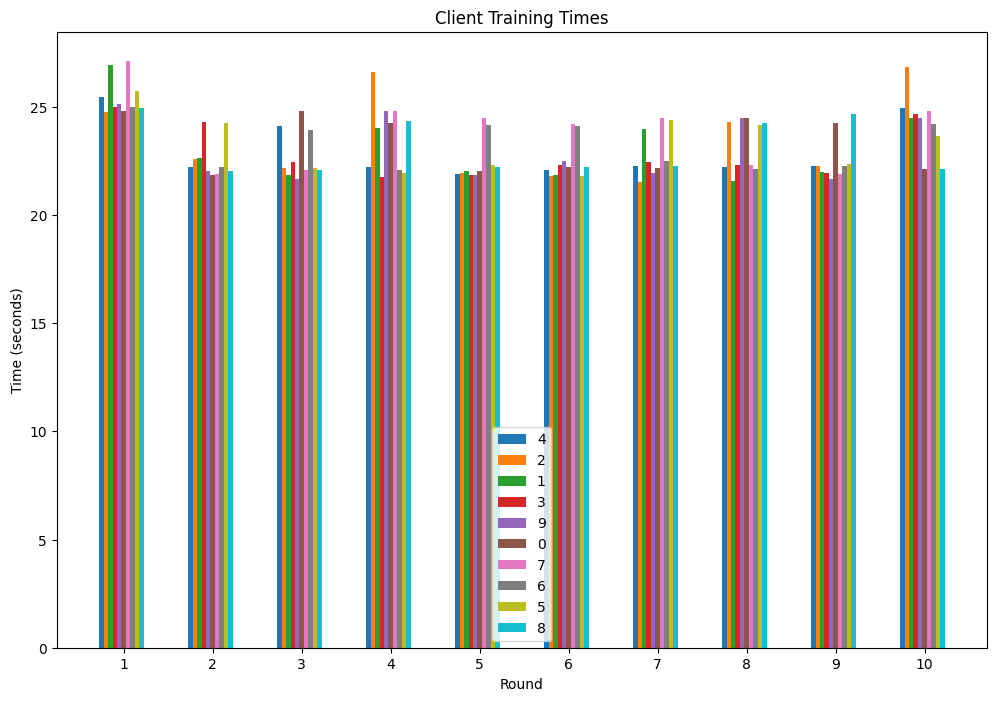

In [39]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [40]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 4 metrics: 92
Client 2 metrics: 94
Client 1 metrics: 93
Client 3 metrics: 92
Client 9 metrics: 94
Client 0 metrics: 93
Client 7 metrics: 93
Client 6 metrics: 92
Client 5 metrics: 92
Client 8 metrics: 92


In [41]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [42]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [43]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-16 09:55:56,849	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 55161045812.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'object_store_memory': 27580522905.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30608) [Client 4] get_parameters
(ClientAppActor pid=30608) [Client 1] fit, config: {}
(ClientAppActor pid=30608) Epoch 0: train loss 0.038056, accuracy 0.553333
(ClientAppActor pid=30608) Epoch 1: train loss 0.021736, accuracy 0.729815
(ClientAppActor pid=34536) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=30608) Epoch 2: train loss 0.018720, accuracy 0.773333
(ClientAppActor pid=44828) Epoch 0: train loss 0.037280, accuracy 0.568519 [repeated 2x across cluster]
(ClientAppActor pid=49060) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=46988) Epoch 2: train loss 0.017995, accuracy 0.783889 [repeated 18x across cluster]
(ClientAppActor pid=34536) Epoch 4: train loss 0.016585, accuracy 0.804815 [repeated 17x across cluster]
(ClientAppActor pid=45576) Epoch 6: train loss 0.014246, accuracy 0.831852 [repeated 18x across cluster]
(ClientAppActor pid=30608) [Client 3] fit, config: {}
(ClientAppActor pid=45332) Ep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45332) Epoch 9: train loss 0.011193, accuracy 0.867407 [repeated 3x across cluster]
(ClientAppActor pid=45332) [Client 3] evaluate, config: {}
(ClientAppActor pid=30608) Client 5 loss 0.017481200943390528
(ClientAppActor pid=30608) Client 5 accuracy 0.8016666666666666


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30608) [Client 6] fit, config: {}
(ClientAppActor pid=30608) Epoch 1: train loss 0.013097, accuracy 0.846111 [repeated 9x across cluster]
(ClientAppActor pid=30608) [Client 4] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=30608) Client 4 loss 0.016186543007691703 [repeated 9x across cluster]
(ClientAppActor pid=30608) Client 4 accuracy 0.83 [repeated 9x across cluster]
(ClientAppActor pid=34536) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=49060) Epoch 3: train loss 0.011032, accuracy 0.865185 [repeated 17x across cluster]
(ClientAppActor pid=45576) Epoch 5: train loss 0.009351, accuracy 0.888333 [repeated 20x across cluster]
(ClientAppActor pid=54976) Epoch 7: train loss 0.008136, accuracy 0.897963 [repeated 18x across cluster]
(ClientAppActor pid=30608) [Client 9] fit, config: {}
(ClientAppActor pid=30608) Epoch 0: train loss 0.014361, accuracy 0.829630 [repeated 17x across cluster]
(ClientAppActor pid=44828) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44828) [Client 4] evaluate, config: {}
(ClientAppActor pid=44828) Client 4 loss 0.011127015401919682
(ClientAppActor pid=44828) Client 4 accuracy 0.8816666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30608) [Client 7] fit, config: {}
(ClientAppActor pid=44828) Epoch 9: train loss 0.006838, accuracy 0.918704 [repeated 3x across cluster]
(ClientAppActor pid=30608) [Client 8] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=30608) Client 8 loss 0.010997582189738751 [repeated 9x across cluster]
(ClientAppActor pid=30608) Client 8 accuracy 0.8716666666666667 [repeated 9x across cluster]
(ClientAppActor pid=45576) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=34536) Epoch 1: train loss 0.009544, accuracy 0.888148 [repeated 16x across cluster]
(ClientAppActor pid=30608) Epoch 4: train loss 0.007830, accuracy 0.905556 [repeated 17x across cluster]
(ClientAppActor pid=44828) Epoch 6: train loss 0.006360, accuracy 0.923704 [repeated 17x across cluster]
(ClientAppActor pid=45576) Epoch 8: train loss 0.004894, accuracy 0.942778 [repeated 18x across cluster]
(ClientAppActor pid=44828) [Client 1] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=44828) Epoch 9: train loss 0.004569, accuracy 0.947778 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46988) [Client 4] evaluate, config: {}
(ClientAppActor pid=46988) Client 4 loss 0.00990684782465299
(ClientAppActor pid=46988) Client 4 accuracy 0.8883333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34536) [Client 8] fit, config: {}
(ClientAppActor pid=34536) Epoch 1: train loss 0.008216, accuracy 0.903148 [repeated 10x across cluster]
(ClientAppActor pid=34536) [Client 0] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=34536) Client 0 loss 0.011257138525446256 [repeated 9x across cluster]
(ClientAppActor pid=34536) Client 0 accuracy 0.8616666666666667 [repeated 9x across cluster]
(ClientAppActor pid=54976) [Client 1] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=30608) Epoch 3: train loss 0.006856, accuracy 0.916481 [repeated 19x across cluster]
(ClientAppActor pid=45332) Epoch 5: train loss 0.004739, accuracy 0.944259 [repeated 17x across cluster]
(ClientAppActor pid=54976) Epoch 7: train loss 0.003765, accuracy 0.956667 [repeated 19x across cluster]
(ClientAppActor pid=46988) [Client 6] fit, config: {}
(ClientAppActor pid=46988) Epoch 0: train loss 0.010020, accuracy 0.888519 [repeated 17x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34536) [Client 5] evaluate, config: {}
(ClientAppActor pid=34536) Client 5 loss 0.01685396338502566
(ClientAppActor pid=34536) Client 5 accuracy 0.8566666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46988) [Client 1] fit, config: {}
(ClientAppActor pid=34536) Epoch 9: train loss 0.003411, accuracy 0.959630 [repeated 3x across cluster]
(ClientAppActor pid=46988) [Client 3] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=46988) Client 3 loss 0.010750350557888548 [repeated 9x across cluster]
(ClientAppActor pid=46988) Client 3 accuracy 0.92 [repeated 9x across cluster]
(ClientAppActor pid=54976) [Client 9] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=54976) Epoch 1: train loss 0.006832, accuracy 0.914259 [repeated 16x across cluster]
(ClientAppActor pid=34536) Epoch 4: train loss 0.004390, accuracy 0.947593 [repeated 17x across cluster]
(ClientAppActor pid=44828) Epoch 6: train loss 0.003178, accuracy 0.962778 [repeated 19x across cluster]
(ClientAppActor pid=30608) Epoch 8: train loss 0.002412, accuracy 0.974444 [repeated 18x across cluster]
(ClientAppActor pid=45576) [Client 7] fit, config: {}
(ClientAppActor pid=34536) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34536) [Client 6] evaluate, config: {}
(ClientAppActor pid=34536) Client 6 loss 0.011014454786976179
(ClientAppActor pid=34536) Client 6 accuracy 0.89


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34536) [Client 4] fit, config: {}
(ClientAppActor pid=34536) Epoch 0: train loss 0.008285, accuracy 0.905926 [repeated 3x across cluster]
(ClientAppActor pid=34536) [Client 8] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=34536) Client 8 loss 0.011533687996367614 [repeated 9x across cluster]
(ClientAppActor pid=34536) Client 8 accuracy 0.9033333333333333 [repeated 9x across cluster]
(ClientAppActor pid=30608) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=44828) Epoch 2: train loss 0.004905, accuracy 0.943519 [repeated 19x across cluster]
(ClientAppActor pid=49060) Epoch 4: train loss 0.003330, accuracy 0.962407 [repeated 18x across cluster]
(ClientAppActor pid=49060) Epoch 6: train loss 0.002490, accuracy 0.972037 [repeated 17x across cluster]
(ClientAppActor pid=54976) Epoch 8: train loss 0.001780, accuracy 0.980556 [repeated 17x across cluster]
(ClientAppActor pid=44828) [Client 7] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45332) Epoch 9: train loss 0.001919, accuracy 0.978704 [repeated 4x across cluster]
(ClientAppActor pid=45332) [Client 4] evaluate, config: {}
(ClientAppActor pid=45332) Client 4 loss 0.01147321571285526
(ClientAppActor pid=45332) Client 4 accuracy 0.905


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45332) [Client 4] fit, config: {}
(ClientAppActor pid=45332) Epoch 1: train loss 0.005321, accuracy 0.935926 [repeated 10x across cluster]
(ClientAppActor pid=45332) [Client 8] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=45332) Client 8 loss 0.012697972121338049 [repeated 9x across cluster]
(ClientAppActor pid=45332) Client 8 accuracy 0.8966666666666666 [repeated 9x across cluster]
(ClientAppActor pid=54976) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=44828) Epoch 3: train loss 0.003189, accuracy 0.962407 [repeated 17x across cluster]
(ClientAppActor pid=54976) Epoch 5: train loss 0.002104, accuracy 0.978333 [repeated 19x across cluster]
(ClientAppActor pid=45576) Epoch 7: train loss 0.001591, accuracy 0.982037 [repeated 18x across cluster]
(ClientAppActor pid=44828) [Client 9] fit, config: {}
(ClientAppActor pid=44828) Epoch 0: train loss 0.008495, accuracy 0.905185 [repeated 18x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30608) [Client 0] evaluate, config: {}
(ClientAppActor pid=30608) Client 0 loss 0.012135315736134846
(ClientAppActor pid=30608) Client 0 accuracy 0.8966666666666666


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54976) [Client 7] fit, config: {}
(ClientAppActor pid=30608) Epoch 9: train loss 0.001203, accuracy 0.988333 [repeated 3x across cluster]
(ClientAppActor pid=45576) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=54976) Client 1 loss 0.010010791157061855 [repeated 9x across cluster]
(ClientAppActor pid=54976) Client 1 accuracy 0.9016666666666666 [repeated 9x across cluster]
(ClientAppActor pid=34536) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=44828) Epoch 1: train loss 0.005207, accuracy 0.939259 [repeated 16x across cluster]
(ClientAppActor pid=49060) Epoch 4: train loss 0.002425, accuracy 0.971852 [repeated 17x across cluster]
(ClientAppActor pid=45576) Epoch 6: train loss 0.002043, accuracy 0.976111 [repeated 18x across cluster]
(ClientAppActor pid=30608) Epoch 8: train loss 0.001550, accuracy 0.982593 [repeated 19x across cluster]
(ClientAppActor pid=49060) [Client 9] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54976) [Client 5] evaluate, config: {}
(ClientAppActor pid=54976) Client 5 loss 0.02080662950252493
(ClientAppActor pid=54976) Client 5 accuracy 0.8633333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44828) [Client 4] fit, config: {}
(ClientAppActor pid=54976) Epoch 0: train loss 0.008549, accuracy 0.912963 [repeated 3x across cluster]
(ClientAppActor pid=44828) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=44828) Client 6 loss 0.012582404464483261 [repeated 9x across cluster]
(ClientAppActor pid=44828) Client 6 accuracy 0.895 [repeated 9x across cluster]
(ClientAppActor pid=49060) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=49060) Epoch 2: train loss 0.002644, accuracy 0.969630 [repeated 19x across cluster]
(ClientAppActor pid=30608) Epoch 4: train loss 0.001845, accuracy 0.979630 [repeated 18x across cluster]
(ClientAppActor pid=45576) Epoch 6: train loss 0.001304, accuracy 0.985000 [repeated 17x across cluster]
(ClientAppActor pid=44828) Epoch 9: train loss 0.000824, accuracy 0.990556 [repeated 17x across cluster]
(ClientAppActor pid=44828) [Client 5] fit, config: {}
(ClientAppActor pid=44828)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45332) Epoch 9: train loss 0.001347, accuracy 0.987037 [repeated 4x across cluster]
(ClientAppActor pid=44828) [Client 1] evaluate, config: {}
(ClientAppActor pid=44828) Client 1 loss 0.011136727215101321
(ClientAppActor pid=44828) Client 1 accuracy 0.9


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45576) [Client 2] fit, config: {}
(ClientAppActor pid=45576) Epoch 1: train loss 0.003258, accuracy 0.960185 [repeated 10x across cluster]
(ClientAppActor pid=45576) [Client 7] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=44828) Client 5 loss 0.021334256703654925 [repeated 9x across cluster]
(ClientAppActor pid=44828) Client 5 accuracy 0.865 [repeated 9x across cluster]
(ClientAppActor pid=46988) [Client 9] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=30608) Epoch 3: train loss 0.001886, accuracy 0.978148 [repeated 18x across cluster]
(ClientAppActor pid=30608) Epoch 5: train loss 0.001250, accuracy 0.987222 [repeated 19x across cluster]
(ClientAppActor pid=46988) Epoch 7: train loss 0.001162, accuracy 0.986296 [repeated 18x across cluster]
(ClientAppActor pid=34536) [Client 7] fit, config: {}
(ClientAppActor pid=34536) Epoch 0: train loss 0.008080, accuracy 0.912037 [repeated 17x across cluster]
(ClientAppActor pid=45576

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45576) [Client 5] evaluate, config: {}
(ClientAppActor pid=45576) Client 5 loss 0.022060725279152392
(ClientAppActor pid=45576) Client 5 accuracy 0.8633333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 533.35s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.016871259858210884
INFO :      		round 2: 0.011657071101168792
INFO :      		round 3: 0.01134354755654931
INFO :      		round 4: 0.012118066200055183
INFO :      		round 5: 0.012331636761625608
INFO :      		round 6: 0.013119107839961846
INFO :      		round 7: 0.014023596206136668
INFO :      		round 8: 0.014492632679912881
INFO :      		round 9: 0.015175505576189607
INFO :      		round 10: 0.015715200812167797
INFO :      


History (loss, distributed):
	round 1: 0.016871259858210884
	round 2: 0.011657071101168792
	round 3: 0.01134354755654931
	round 4: 0.012118066200055183
	round 5: 0.012331636761625608
	round 6: 0.013119107839961846
	round 7: 0.014023596206136668
	round 8: 0.014492632679912881
	round 9: 0.015175505576189607
	round 10: 0.015715200812167797

(ClientAppActor pid=34536) Client 8 loss 0.015511193275451661
(ClientAppActor pid=34536) Client 8 accuracy 0.8983333333333333


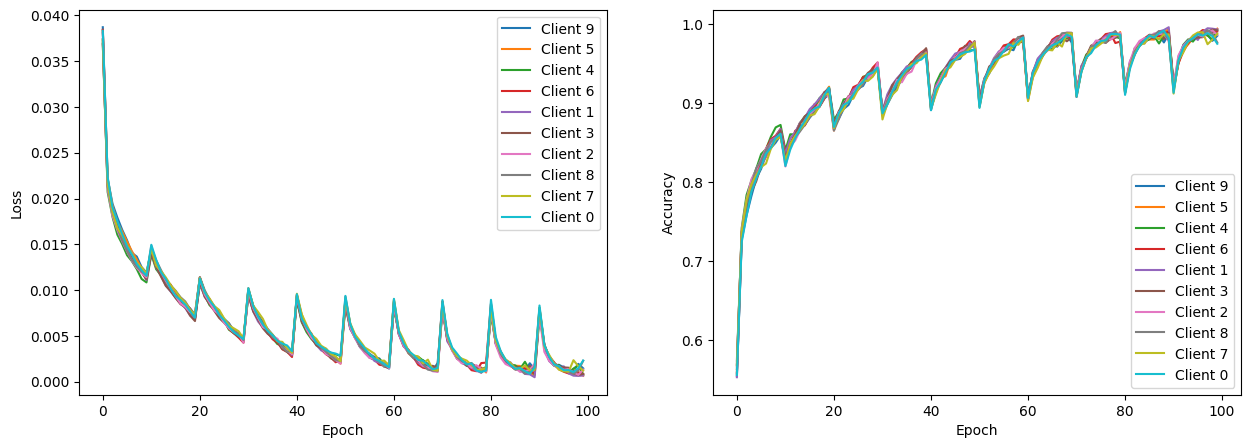

In [44]:
plot_metrics(strategy_fed_avg.client_metrics)

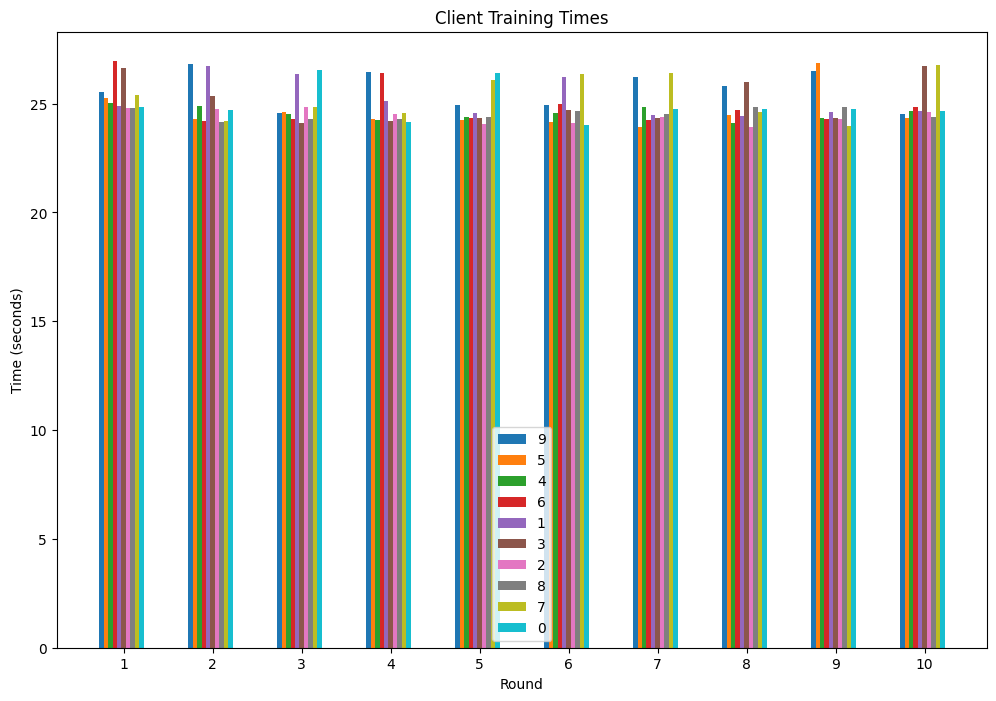

In [45]:
plot_times(strategy_fed_avg.client_training_times)